## Install libraries

In [1]:
!pip3 install snntorch --quiet
!pip install speech2spikes --quiet

## Imports

In [2]:
# from google.colab import drive

from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
import torch.nn.functional as F

import snntorch as snn
from snntorch import surrogate
from snntorch import backprop
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikeplot as splt

from sklearn import preprocessing

from sklearn.metrics import confusion_matrix

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

from tqdm import tqdm

/tmp/ipykernel_34/1576457613.py:10: DeprecationWarning: The module snntorch.backprop will be deprecated in  a future release. Writing out your own training loop will lead to substantially faster performance.
  from snntorch import backprop


## Mount google drive

In [138]:
# drive.mount('/content/drive/')

## Select device

In [21]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Training on", device)

Training on cuda


## Dataset class

In [42]:
class AudioDataset(Dataset):
    def __init__(self, data_filepath, labels_filepath):
        self.data = np.load(data_filepath)
        self.labels = np.load(labels_filepath)
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data[idx]
        label = self.labels[idx]
        return data, label
    
features_path = '/kaggle/input/audio-dataset/mfcc_features.npy'
labels_path = '/kaggle/input/audio-dataset/labels.npy'
dataset = AudioDataset(data_filepath=features_path, labels_filepath=labels_path)

## Normalize function

In [43]:
def normalize(data):
    data = (data - np.min(data, axis=0)) / (np.max(data, axis=0) - np.min(data, axis=0)) 
    return data

## Dataloader

In [44]:
# split the dataset into three parts (train 70%, test 15%, validation 15%)
test_size = 0.15
val_size = 0.15

test_amount, val_amount = int(dataset.__len__() * test_size), int(dataset.__len__() * val_size)

train_set, val_set, test_set = torch.utils.data.random_split(dataset, [
            (dataset.__len__() - (test_amount + val_amount)),
            test_amount,
            val_amount
])

# train_set.dataset.data = normalize(train_set.dataset.data)
# val_set.dataset.data = normalize(val_set.dataset.data)
# test_set.dataset.data = normalize(test_set.dataset.data)

B = 128

train_dataloader = torch.utils.data.DataLoader(
            train_set,
            batch_size=B,
            shuffle=True,
            drop_last=True,
)
val_dataloader = torch.utils.data.DataLoader(
            val_set,
            batch_size=B,
            shuffle=False,
            drop_last=True,
)
test_dataloader = torch.utils.data.DataLoader(
            test_set,
            batch_size=B,
            shuffle=False,
            drop_last=True,
)

## Train/eval functions

In [45]:
def train_epoch(model, train_dataloader, loss_crt, optimizer, device):
    """
    model: Model object
    train_dataloader: DataLoader over the training dataset
    loss_crt: loss function object
    optimizer: Optimizer object
    device: torch.device('cpu) or torch.device('cuda')

    The function returns:
     - the epoch training loss, which is an average over the individual batch
       losses
    """
    model.train()
    epoch_loss = 0.0
    epoch_accuracy = 0.0
    number_samples = 0
    num_batches = len(train_dataloader)

    print('Train epoch')
    for batch_idx, batch in tqdm(enumerate(train_dataloader), unit="batch", total=len(train_dataloader)):
        # shape: batch_size x 13 x 87, batch_size 
        batch_data, batch_labels = batch

        # move data to GPU
        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)

        spk_rec, _ = model(batch_data)
        assert spk_rec.shape == (time_steps ,B, 9)
    
        # Sum over all simulation of num_steps iterations
        spike_count = spk_rec.sum(0)
        assert spike_count.shape == (B, 9)

        # intialize the loss and sum over time
        loss_val = torch.zeros((1), dtype=torch.float, device=device)
        loss_val += loss_crt(spike_count, batch_labels)
        
        # Gradient calculation + weight update
        # set all gradients to 0
        optimizer.zero_grad()
        # BACKPROPAGATE the gradients
        loss_val.backward()
        # use the gradients to OPTIMISE the model
        optimizer.step()
        
        epoch_loss += loss_val.item()
        
        # Calculate accuracy
        _, max_spike = spike_count.max(1)

        # correct classes for one batch
        num_correct = (max_spike == batch_labels).sum()

        # total accuracy
        number_samples += len(batch_labels)
        epoch_accuracy += num_correct

        
    epoch_loss = epoch_loss / num_batches
    epoch_accuracy = epoch_accuracy / number_samples

    return epoch_accuracy.item(), epoch_loss


def eval_epoch(model, val_dataloader, loss_crt, device):
    """
    model: Model object
    val_dataloader: DataLoader over the validation dataset
    loss_crt: loss function object
    device: torch.device('cpu) or torch.device('cuda')

    The function returns:
     - the epoch validation loss, which is an average over the individual batch
       losses
    """
    model.eval()
    epoch_loss = 0.0
    epoch_accuracy = 0.0
    number_samples = 0
    num_batches = len(val_dataloader)
    with torch.no_grad():
        print('Eval epoch')
        for batch_idx, batch in tqdm(enumerate(val_dataloader), unit="batch", total=len(val_dataloader)):
            # shape: batch_size x 13 x 345, batch_size
            batch_data, batch_labels = batch

            # move data to GPU
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)

            spk_rec, _ = model(batch_data)
            assert spk_rec.shape == (time_steps ,B, 9)
            
            # Sum over all simulation of num_steps iterations
            spike_count = spk_rec.sum(0)
            assert spike_count.shape == (B, 9)

            # intialize the loss and sum over time
            loss_val = torch.zeros((1), dtype=torch.float, device=device)
            loss_val += loss_crt(spike_count, batch_labels)

            epoch_loss += loss_val.item()
            
            # Calculate accuracy
            _, max_spike = spike_count.max(1)

            # correct classes for one batch
            num_correct = (max_spike == batch_labels).sum()

            # total accuracy
            number_samples += len(batch_labels)
            epoch_accuracy += num_correct


    epoch_loss = epoch_loss / num_batches
    epoch_accuracy = epoch_accuracy / number_samples

    return epoch_accuracy.item(), epoch_loss

## Neuron and simulation parameters

In [46]:
num_input = 13
num_hidden = 128
num_output = 9

beta_lif1 = torch.rand(num_hidden)
beta_lif2 = torch.rand(num_output)
threshold_lif1 = torch.rand(num_hidden)
threshold_lif2 = torch.rand(num_output)
time_steps = 345

## Model class

## Hyperparameters

In [47]:
class AccentClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(in_features = num_input, out_features = num_hidden)
        self.lif1 = snn.Leaky(beta=beta_lif1, learn_beta=True, threshold=threshold_lif1, learn_threshold=True)
        self.fc2 = nn.Linear(in_features = num_hidden, out_features = num_output)
        self.lif2 = snn.Leaky(beta=beta_lif2, learn_beta=True, threshold=threshold_lif2, learn_threshold=True)


    def forward(self, x):
        # Initialize hidden states and outputs at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        
        # Record the final layer over time
        mem_rec = []
        spk_rec = []

        # time-loop
        for step in range(time_steps):
            cur1 = self.fc1(x[:, :, step])
            assert cur1.shape == (B, num_hidden)
            spk1, mem1 = self.lif1(cur1, mem1)
            assert spk1.shape == (B, num_hidden)
                
            cur2 = self.fc2(spk1)
            assert cur2.shape == (B, num_output)
            spk2, mem2 = self.lif2(cur2, mem2)
            assert spk2.shape == (B, num_output)
            
            spk_rec.append(spk2)
            mem_rec.append(mem2)

        spk_rec = torch.stack(spk_rec, dim=0)
        mem_rec = torch.stack(mem_rec, dim=0)
        
        assert spk_rec.shape == (time_steps, B, num_output)
        assert mem_rec.shape == (time_steps, B, num_output)
        
        return spk_rec, mem_rec

model = AccentClassifier().to(device)

In [48]:
hyperparams = {
    'lr': 1e-3,
    'betas': (0.9, 0.999),
    'num_epochs': 15,
    'optimizer': "adam",
    'momentum': 0.9,
}

loss_criterion = nn.CrossEntropyLoss()

if hyperparams['optimizer'] == 'adam':
    optimizer = torch.optim.Adam(
        params=model.parameters(),
        lr=hyperparams['lr'],
        betas=hyperparams['betas']
    )
elif hyperparams['optimizer'] == 'sgd':
    optimizer = torch.optim.SGD(
        params=model.parameters(),
        lr=hyperparams['lr'],
        momentum=hyperparams['momentum']
    )

## Train loop

In [49]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(1, hyperparams['num_epochs'] + 1):
    train_accuracy, train_loss = train_epoch(model, train_dataloader, loss_criterion, optimizer, device)
    val_accuracy, val_loss = eval_epoch(model, val_dataloader, loss_criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print('\nEpoch %d'%(epoch))
    print('train loss: %10.8f, accuracy: %10.8f'%(train_loss, train_accuracy))
    print('val loss: %10.8f, accuracy: %10.8f'%(val_loss, val_accuracy))

Train epoch


100%|██████████| 94/94 [01:03<00:00,  1.47batch/s]


Eval epoch


100%|██████████| 20/20 [00:05<00:00,  3.38batch/s]



Epoch 1
train loss: 37.14930178, accuracy: 0.32480052
val loss: 1.76766443, accuracy: 0.49726564
Train epoch


100%|██████████| 94/94 [01:03<00:00,  1.48batch/s]


Eval epoch


100%|██████████| 20/20 [00:05<00:00,  3.39batch/s]



Epoch 2
train loss: 1.37432628, accuracy: 0.70885968
val loss: 1.07915945, accuracy: 0.84218752
Train epoch


100%|██████████| 94/94 [01:03<00:00,  1.48batch/s]


Eval epoch


100%|██████████| 20/20 [00:06<00:00,  3.31batch/s]



Epoch 3
train loss: 0.89165306, accuracy: 0.87466753
val loss: 0.80154708, accuracy: 0.90273440
Train epoch


100%|██████████| 94/94 [01:03<00:00,  1.47batch/s]


Eval epoch


100%|██████████| 20/20 [00:05<00:00,  3.35batch/s]



Epoch 4
train loss: 0.74964172, accuracy: 0.91098732
val loss: 0.78241827, accuracy: 0.93085939
Train epoch


100%|██████████| 94/94 [01:03<00:00,  1.48batch/s]


Eval epoch


100%|██████████| 20/20 [00:05<00:00,  3.41batch/s]



Epoch 5
train loss: 0.64902174, accuracy: 0.92237365
val loss: 0.72562158, accuracy: 0.92968750
Train epoch


100%|██████████| 94/94 [01:03<00:00,  1.49batch/s]


Eval epoch


100%|██████████| 20/20 [00:05<00:00,  3.40batch/s]



Epoch 6
train loss: 0.46570562, accuracy: 0.94672537
val loss: 0.48105337, accuracy: 0.95195311
Train epoch


100%|██████████| 94/94 [01:02<00:00,  1.50batch/s]


Eval epoch


100%|██████████| 20/20 [00:05<00:00,  3.43batch/s]



Epoch 7
train loss: 0.40667296, accuracy: 0.95445478
val loss: 0.46480454, accuracy: 0.95273441
Train epoch


100%|██████████| 94/94 [01:03<00:00,  1.49batch/s]


Eval epoch


100%|██████████| 20/20 [00:05<00:00,  3.34batch/s]



Epoch 8
train loss: 0.59708260, accuracy: 0.93824798
val loss: 0.72784190, accuracy: 0.93789065
Train epoch


100%|██████████| 94/94 [01:02<00:00,  1.50batch/s]


Eval epoch


100%|██████████| 20/20 [00:05<00:00,  3.36batch/s]



Epoch 9
train loss: 0.42696478, accuracy: 0.95595080
val loss: 0.46178275, accuracy: 0.95585936
Train epoch


100%|██████████| 94/94 [01:02<00:00,  1.49batch/s]


Eval epoch


100%|██████████| 20/20 [00:05<00:00,  3.42batch/s]



Epoch 10
train loss: 0.38887311, accuracy: 0.95885968
val loss: 0.32860755, accuracy: 0.96679688
Train epoch


100%|██████████| 94/94 [01:02<00:00,  1.50batch/s]


Eval epoch


100%|██████████| 20/20 [00:05<00:00,  3.46batch/s]



Epoch 11
train loss: 0.38256912, accuracy: 0.96110368
val loss: 0.40165355, accuracy: 0.96132815
Train epoch


100%|██████████| 94/94 [01:02<00:00,  1.50batch/s]


Eval epoch


100%|██████████| 20/20 [00:05<00:00,  3.44batch/s]



Epoch 12
train loss: 0.47821684, accuracy: 0.96293217
val loss: 0.36265183, accuracy: 0.97343749
Train epoch


100%|██████████| 94/94 [01:02<00:00,  1.49batch/s]


Eval epoch


100%|██████████| 20/20 [00:05<00:00,  3.37batch/s]



Epoch 13
train loss: 0.43663716, accuracy: 0.96251661
val loss: 0.29290900, accuracy: 0.97304690
Train epoch


100%|██████████| 94/94 [01:02<00:00,  1.50batch/s]


Eval epoch


100%|██████████| 20/20 [00:05<00:00,  3.43batch/s]



Epoch 14
train loss: 0.21777830, accuracy: 0.97739357
val loss: 0.33549426, accuracy: 0.96757811
Train epoch


100%|██████████| 94/94 [01:02<00:00,  1.51batch/s]


Eval epoch


100%|██████████| 20/20 [00:05<00:00,  3.39batch/s]


Epoch 15
train loss: 0.32332227, accuracy: 0.96600729
val loss: 0.54042398, accuracy: 0.96250004


## Test accuracy

In [ ]:
test_accuracy, test_loss = eval_epoch(model, test_dataloader, loss_criterion, device)
print('test loss: %10.8f, accuracy: %10.8f'%(test_loss, test_accuracy))

## Accuracy and loss plot

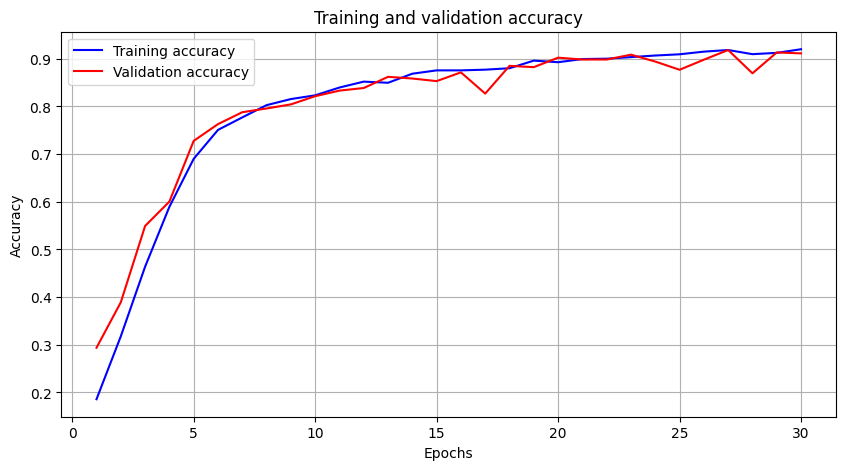

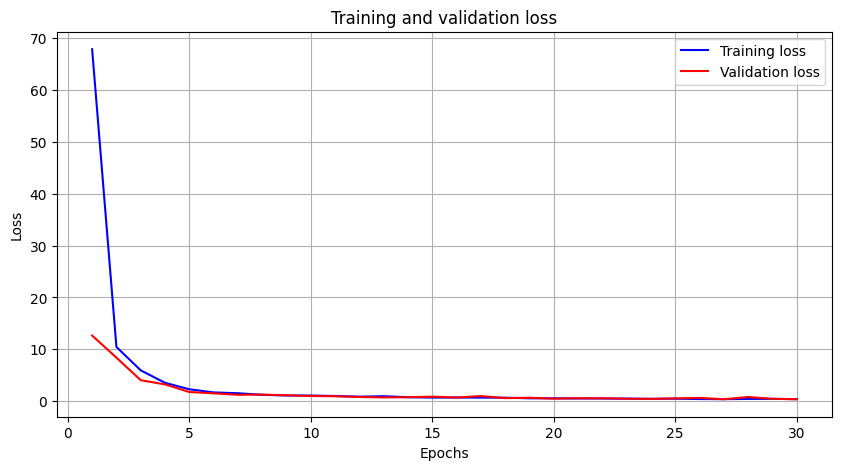

In [144]:
# Data
epochs = range(1, 31)

# Plotting accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plotting loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def get_predictions_and_labels(model, dataloader, device):
    model.eval()
    predictions = []
    labels = []
    with torch.no_grad():
        for batch_idx, batch in tqdm(enumerate(val_dataloader)):
            batch_mfcc, batch_labels = batch
            current_batch_size = batch_mfcc.size(0)

            # move data to GP
            batch_mfcc = batch_mfcc.to(device)
            batch_labels = batch_labels.to(device)

            # batch_size x 10
            output = model(batch_mfcc)

            predictions.append(output.argmax(dim=1, keepdim=True))
            labels.append(batch_labels)

    predictions = torch.cat(predictions, dim=0)
    labels = torch.cat(labels, dim=0)

    return predictions, labels

## Confusion matrix

In [ ]:
predictions, labels = get_predictions_and_labels(model, test_dataloader, device)
cm = confusion_matrix(labels.cpu().numpy(), predictions.cpu().numpy())

163it [00:00, 685.48it/s]


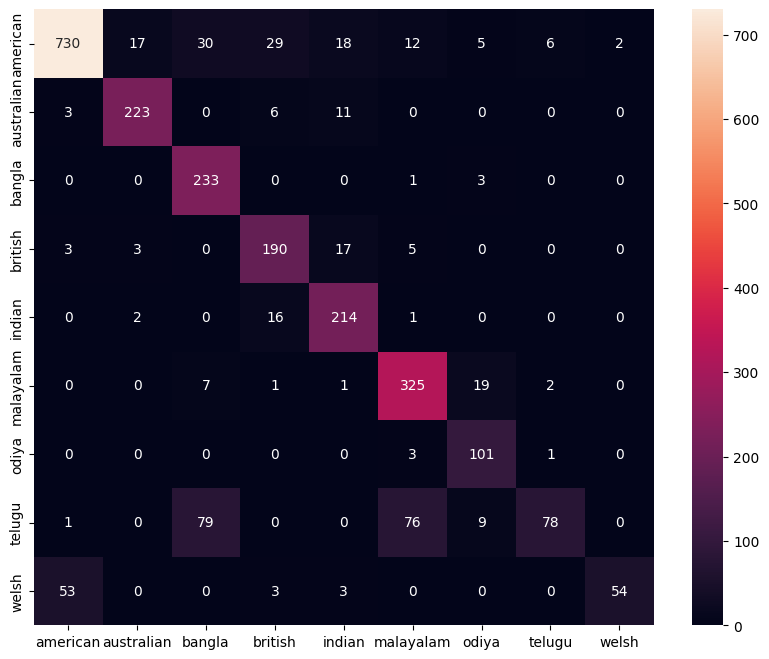

In [ ]:
labels = ["american", "australian", "bangla", "british", "indian", "malayalam", "odiya", "telugu", "welsh"]

df_cm = pd.DataFrame(cm, index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (10, 8))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.savefig('/content/drive/MyDrive/licenta/confustionMatrix')